
# Lab on Introduction to "Learning based beamforming in ultrasound imaging"
---
# Topic 1: Introduction to Ultrasound Imaging Signal Chain

---

The dataset used is from https://zenodo.org/records/7986407 and cite the following references if you are using it. In case downloading dataset using 'gdown' doesn't work, use the below code or download and upload the data from the drive link: (https://drive.google.com/file/d/1xiBB2AIKFWdjE23qjHo6-Xzeme0ztGgH/view?usp=sharing)


---



*References: Schoop, R. A. L. (2023). Ultrasound Plane Wave Raw Data 75 Angles - Breast Phantom and Calibration Phantom Dataset (v1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7986407*

# Import necessary libraries

In [1]:
# Common libraries
import numpy as np
import zipfile # for zipping the files
import os
import h5py # To extract the ultrasound data which is stored in .h5 format
from scipy.interpolate import interp1d # For delay adjustment in ultrasound using 1D cubic interpolation
import matplotlib.pyplot as plt # For plotting the data
from scipy.signal import hilbert # For envelope detection
import cv2 # For resampling the data

#Read the data and store in the colab local space

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/medical_img_reconstruction

/content/drive/MyDrive/medical_img_reconstruction


In [6]:
!ls

'Copy of W6_Medical_Image_Recon_DL.ipynb'  'Copy of W6_Medical_Image_Recon_Traditional.ipynb'


In [7]:
!pip install gdown
import gdown

In [8]:
# Step 1: Download the zip file from Google Drive
file_id = '1xiBB2AIKFWdjE23qjHo6-Xzeme0ztGgH'  # Replace with your file ID
output_path = '/content/sample_data.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xiBB2AIKFWdjE23qjHo6-Xzeme0ztGgH
To: /content/sample_data.zip
100%|██████████| 13.5M/13.5M [00:00<00:00, 68.9MB/s]


'/content/sample_data.zip'

In [9]:
# Path to your zip file in Google Drive
zip_path = '/content/sample_data.zip'

# Directory where you want to extract the files
extract_dir = '/content'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check extracted files
os.listdir(extract_dir)

['.config', 'sample_data.zip', 'drive', 'sample_data']

In [10]:
filePath = '/content/sample_data/data_1.h5'
with h5py.File(filePath, "r") as dataFrame:
  rawData = np.array(dataFrame['data'], dtype="float32")
  rawData = np.moveaxis(rawData, [0, 1], [1, 0])
  # Initialize an empty dictionary to hold the parameters (attributes)
  parameters = {}

  # Read all the attributes associated with the data
  for key, value in dataFrame['/data'].attrs.items():
      parameters[key] = value

  fc = parameters['fc']
  fs = parameters['fs']
  transmit_delays = parameters['transmit_delays']
  probe_name = parameters['probe_name']

# Visualize the data

(2176, 128)


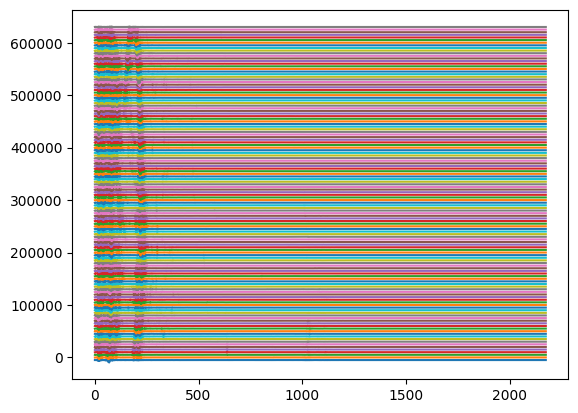

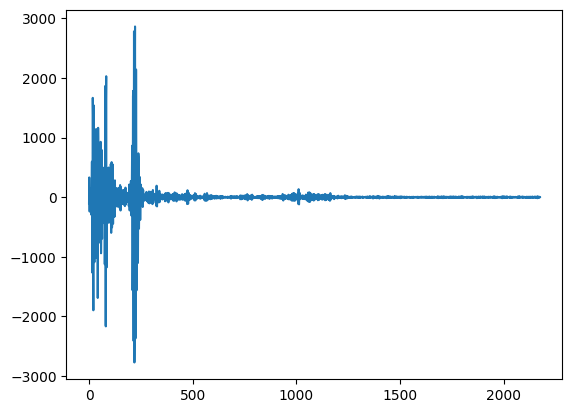

In [11]:
print(np.shape(rawData))
def viz_raw_data(rawData):
  for ii in range(np.shape(rawData)[1]):
      plt.plot(rawData[:,ii]+((ii-1)*5000))
  plt.show()
viz_raw_data(rawData)
plt.plot(rawData[:,64])
plt.show()

# The classical beamforming
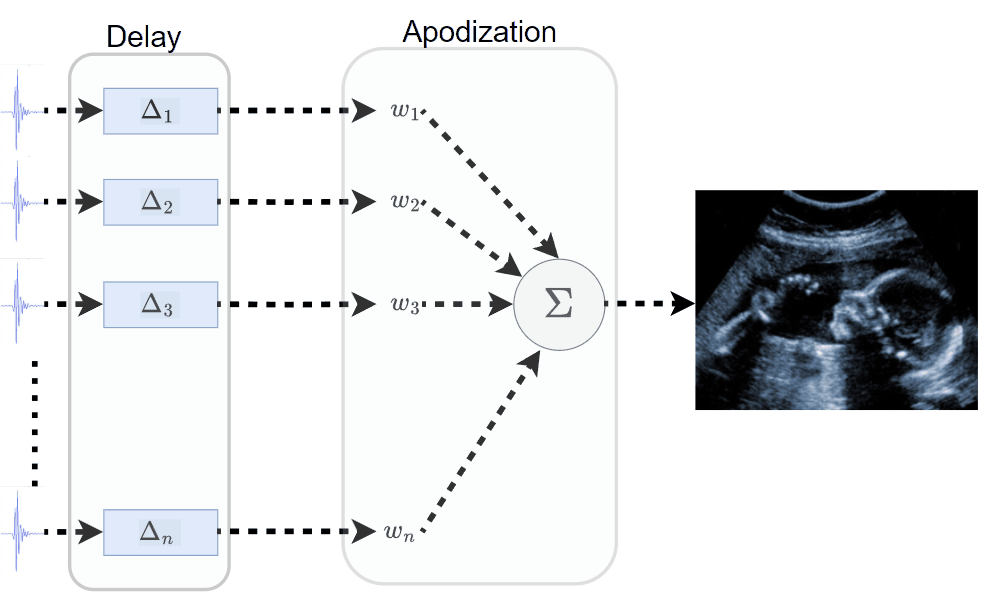
---
This has delay function (used to map time to space for each transducer element i.e. Array of size Nd x Nch becomes that of size Nr x Nc x Nch
---
where Nd = Number of samples in depth (time), Nch = Number of Transducer elements, Nr, Nc = Number of rows and columns in the final image
---

In [24]:
# Time to space mapping
def time_to_space_mapping(rawData, rows, columns, fs):
    c = 1540  # Speed of sound in tissue (m/s)
    N_elements = rawData.shape[1]  # Number of elements in the probe

    # Probe geometry (hardcoded)
    probe_geometry = np.linspace(-0.019105, 0.019105, 128)

    # Time vector
    timeVector = np.arange(rawData.shape[0]) / fs

    # Generate x and z axes
    x_axis = np.linspace(probe_geometry[0], probe_geometry[-1], columns)
    z_axis = 0.5 * c * timeVector  # Half time (going, not coming back)

    # Meshgrid
    x_grid, z_grid = np.meshgrid(x_axis, z_axis)

    # Flatten x_grid and z_grid to vectors (similar to MATLAB `(:)` operation)
    x = x_grid.ravel()
    z = z_grid.ravel()

    # Initialize the output matrix
    tofc = np.zeros((rows * columns, N_elements))

    # Transmit delay (same for all elements)
    transmit_delay = z

    # Loop through each element and calculate the receive delay, total delay, and interpolate
    for nrx in range(N_elements):
        # Receive delay
        receive_delay = np.sqrt((probe_geometry[nrx] - x) ** 2 + z ** 2)

        # Total delay
        delay = (transmit_delay + receive_delay) / c

        # Interpolation with cubic spline
        # rawData is amplitude
        interp_func = interp1d(timeVector, rawData[:, nrx], kind='cubic', fill_value=0, bounds_error=False)
        # interpolation to find the corresponding values to all pixels
        tofc[:, nrx] = interp_func(delay)

    # Reshape tofc to the same size as x_grid, z_grid, and round
    tofc = tofc.reshape(x_grid.shape[0], x_grid.shape[1], N_elements)

    return tofc

In [13]:
# For beam summing using delay and sum
def apodization(distance, aperture, window_type='hanning'):
    """Function to compute the apodization, given distance, aperture, and window type."""
    if window_type == 'hanning':
        # Hanning window (based on cosine function)
        apod = np.zeros_like(distance)
        apod[distance <= aperture] = 0.5 * (1 + np.cos(np.pi * distance[distance <= aperture] / aperture[distance <= aperture]))
        return apod
    else:
        raise ValueError(f"Window type {window_type} not supported.")

def DAS(dataCube, x_grid, z_grid, probe_geometry):
    """
    Implements the conventional Delay And Sum (DAS) beamforming.

    this function does the weightage

    Parameters:
        dataCube (numpy.ndarray): 3D data cube (pixels x time x elements)
        x_grid (numpy.ndarray): x coordinates of the grid (pixels x 1)
        z_grid (numpy.ndarray): z coordinates of the grid (pixels x 1)
        probe_geometry (numpy.ndarray): geometry of the probe elements

    Returns:
        numpy.ndarray: beamformed data (pixels x 1)
    """
    N_elements = dataCube.shape[2]  # Number of elements in the probe

    # Flatten x_grid and z_grid
    x = x_grid.ravel()
    z = z_grid.ravel()

    # Number of pixels in the grid
    pixels = z_grid.shape[0] * z_grid.shape[1]

    # F-number and aperture calculation
    rx_f_number = 1.75
    rx_aperture = z / rx_f_number

    # Calculate the aperture distance (between grid points and probe elements)
    rx_aperture_distance = np.abs(np.outer(x, np.ones(N_elements)) - np.outer(np.ones(pixels), probe_geometry))

    # Apodization using the Hanning window
    receive_apodization = apodization(rx_aperture_distance, np.outer(rx_aperture, np.ones(N_elements)), window_type='hanning')

    # Beamforming: Sum over the elements, using the apodization and dataCube
    beamformedData = np.sum(receive_apodization * dataCube.reshape(pixels, N_elements), axis=1)

    # Reshape beamformed data back to the grid shape
    beamformedData = beamformedData.reshape(x_grid.shape)

    return beamformedData


First do the time to space mapping and display the result

In [14]:
rows = 2176
columns = 128
tofc = time_to_space_mapping(rawData, rows, columns, fs)

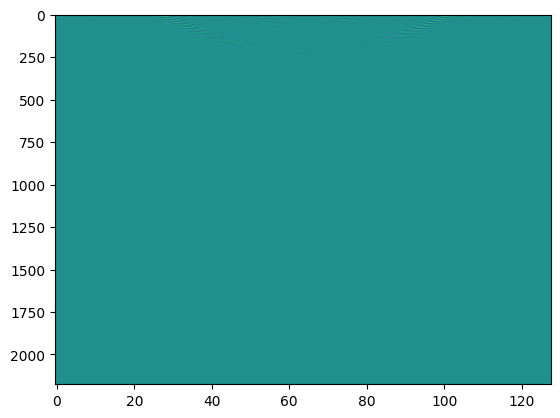

In [15]:
trns_idx = 64
plt.imshow(tofc[:,:,trns_idx],aspect='auto')
plt.show()

Actual Beamformation using the space data and display the result

In [16]:
# Probe geometry
probe_geometry = np.linspace(-0.019105, 0.019105, 128)

# Time vector
timeVector = np.arange(rawData.shape[0]) / fs

# Generate x and z axes
c = 1540
x_axis = np.linspace(probe_geometry[0], probe_geometry[-1], columns)
z_axis = 0.5 * c * timeVector  # Half time (going, not coming back)

# Meshgrid
x_grid, z_grid = np.meshgrid(x_axis, z_axis)

# Perform beamforming
beamformedData = DAS(tofc, x_grid, z_grid, probe_geometry)
# put all NaNs to zeros
beamformedData[np.isnan(beamformedData)]=0

<ipython-input-13-c236272d5dbe>:7: RuntimeWarning: invalid value encountered in divide
  apod[distance <= aperture] = 0.5 * (1 + np.cos(np.pi * distance[distance <= aperture] / aperture[distance <= aperture]))


<ipython-input-17-3e27da12b72f>:6: RuntimeWarning: divide by zero encountered in log10
  DAS_image = 20*np.log10(np.abs(hilbert(beamformed_DASnorm)))


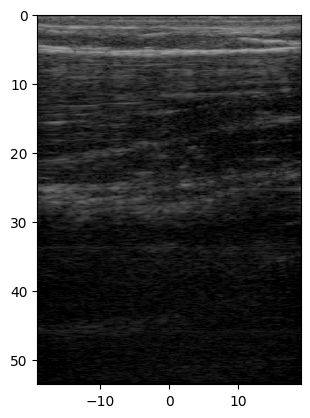

In [17]:
# Display the result

# Normalization
beamformed_DASnorm = beamformedData/np.linalg.norm(beamformedData)
# Envelope Detection and log compression
DAS_image = 20*np.log10(np.abs(hilbert(beamformed_DASnorm)))
# Correction for infinity due to log
DAS_image[np.isinf(DAS_image)]=0
DAS_image[np.isnan(DAS_image)]=0

extent = [x * 1e3 for x in [x_axis[0], x_axis[-1], z_axis[-1], z_axis[0]]]  # In mm
plt.imshow(DAS_image, extent=extent, cmap='gray', clim=[-80, 0])
plt.show()

# Beamforming using accelerated library


---


Let's employ the ultraspy library to accelerate things and try out different beamforming algorithms


---

Ultraspy:https://ultraspy.readthedocs.io/en/latest/
Cupy: https://cupy.dev/


---



In [18]:
!pip install ultraspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.3/166.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 33.9 MB/s eta 0:00:00


In [19]:
import cupy as cp
from ultraspy.beamformers.das import DelayAndSum
from ultraspy.beamformers.capon import Capon
import ultraspy as us
from ultraspy.probes.factory import get_probe
from ultraspy.scan import GridScan

The beamformer using ultraspy library

In [20]:
def pybeamforming (beamformer, data,probe,transmit_delays,fs):

    elements_indices = np.arange(probe.nb_elements)
    nb_transmissions = transmit_delays.shape[0]
    acquisition_info = {
        'sampling_freq': fs,
        't0': 0,
        'prf': 1000,
        'signal_duration': None,
        'delays': transmit_delays,
        'sound_speed': 1540,
        'sequence_elements': {
            'emitted': np.tile(elements_indices, (nb_transmissions, 1)),
            'received': np.tile(elements_indices, (nb_transmissions, 1)),
        }
    }

    #%% Beamformer Selection
    beamformer.automatic_setup(acquisition_info, probe)

    # Additional parameters
    beamformer.update_setup('f_number', 1.75)

    #Options: https://ultraspy.readthedocs.io/en/latest/architecture/beamformer_class.html
    beamformer.update_option('reduction', 'sum')
    beamformer.update_option('rx_apodization', 'boxcar')
    beamformer.update_option('rx_apodization_alpha', '0.1')
    beamformer.update_option('compound', 'True')


    # Zone of interest (in m)
    x = np.linspace(probe.geometry[0,0],probe.geometry[0,-1], 128)
    if (len(np.shape(data)) > 2):
        z = np.linspace(0, 0.06, np.shape(data)[2])
    else:
        z = np.linspace(0, 0.06, np.shape(data)[1])

    # Then define a regular grid for the beamforming
    scan = GridScan(x, z)


    # Get the first frame
    first_frame = data

    # On GPU mode, the data needs to be sent to the memory of the GPU.
    # If is also possible to send directly the numpy array, then the
    # beamformer will handle it. However, if you want to apply many
    # beamformers / setups or whatever on the same data, this will
    # prevent it to be stored multiple times on GPU
    d_data = cp.asarray(first_frame, np.float32)

    # Actual beamforming operation, then we compute its envelope
    d_output = beamformer.beamform(d_data, scan)
    d_envelope = beamformer.compute_envelope(d_output, scan)

    # Get the B-Mode to display
    us.to_b_mode(d_envelope)

    # Get the B-Mode back on CPU memory
    b_mode = d_envelope.get()

    return b_mode, x, z

In [21]:
#Extent the data as the expectation is data of dimensions Ntranmsit x Number of samples x Number of Transducers
data = rawData
data = np.moveaxis(data, [1, 0], [0, 1])
data = np.expand_dims(data, axis=0)
# Build the probe
probe = get_probe(probe_name)
probe.set_central_freq(fc)
if (len(transmit_delays.shape)<2):
  transmit_delays = np.expand_dims(transmit_delays, axis=0)

In [22]:
#beamformer = Capon(diagonal_loading_mode=False,l_prop=0.5, delta_l=100)
beamformer = DelayAndSum() #Set the beamform class based on the desired import
b_mode,x, z = pybeamforming (beamformer, data,probe,transmit_delays,fs)

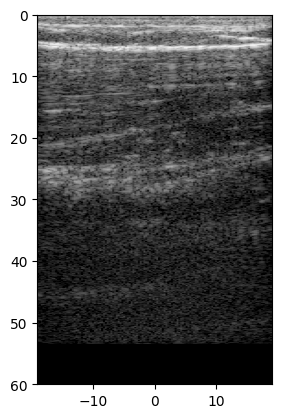

In [23]:
plt.figure()
extent = [x * 1e3 for x in [x[0], x[-1], z[-1], z[0]]]  # In mm
plt.imshow(b_mode.T, extent=extent, cmap='gray', clim=[-60, 0])
plt.show()